## Predicting house prices on the Kaggle dataset

1. Data cleaning & feature engineering
1. Regression
1. Clustering to obtain house price bins, then classification: for fum

### Get packages & data

In [1]:
# get packages

import mglearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# show matplotlib plots nicely
%matplotlib inline

In [2]:
# get data

# !kaggle competitions download -c house-prices-advanced-regression-techniques

In [3]:
# I only really need the "train" data, ie data that has labels
# (since I'm not trying to take part in the competition and predict the unlabelled data)
train_original = pd.read_csv('data/train.csv')

## Inspect data

In [4]:
display(train_original.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
display(train_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

None

## Plan:

### Data cleaning
1. Drop needless columns: any column with fewer than 1300 non-null value
1. Fill in null values in the other columns
    1. Will need to explore data & figure out best ways to do this for each column
1. Massage each non-numeric columns
    1. Explore data
    1. One-hot encode or do something else (or drop if doesn't seem useful)
1. Massage numeric columns
    1. Explore data, eg plots
    1. Get rid of crazy outlyers?
        1. Clip (eg log / sqrt)
        1. Normalise (check what would be the best way to do this)

### Modelling: Regression
1. Explore cross-validation
1. Explore different model performance metrics
1. Explore crazy feature engineering, eg polynomials etc
1. Explore if dimension reduction could be useful
    1. eg PCA
1. Try out various regression models
    1. Linear regression
    1. Ridge regression
    1. Lasso regression
    1. Tress for regression (?): decision, gradient-boosted, random forest

### Modelling: Crazy classification
1. Do clustering on house prices to see if there are "meaningful" / "obvious" classes
    1. k-means or Agglomerative clustering
1. Group house prices into bins, as discovered from clustering
1. Try classification on the data
    1. knn
    1. Logistic regression
    1. SVM
    1. Trees for classification: decision, gradient-boosted, random forest

## Data cleaning

In [6]:
# drop columns that have fewer than 771 non-null values
data = train_original.dropna(thresh = 771, axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

# Deal with null values in numeric columns

In [8]:
pd.options.display.max_columns = None
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


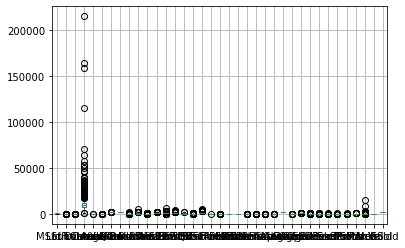

In [9]:
data.iloc[:,:-1].boxplot()
# don't show the distribution for prices

In [10]:
# get a list of numeric columns that contain nan

# select numeric columns
data_num = data.select_dtypes(include=np.number)
display(data_num.info())

# list of columns that have nan
num_cols_with_nan = data_num.columns[data_num.isna().any()].tolist()
display(num_cols_with_nan)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   OverallCond    1460 non-null   int64  
 6   YearBuilt      1460 non-null   int64  
 7   YearRemodAdd   1460 non-null   int64  
 8   MasVnrArea     1452 non-null   float64
 9   BsmtFinSF1     1460 non-null   int64  
 10  BsmtFinSF2     1460 non-null   int64  
 11  BsmtUnfSF      1460 non-null   int64  
 12  TotalBsmtSF    1460 non-null   int64  
 13  1stFlrSF       1460 non-null   int64  
 14  2ndFlrSF       1460 non-null   int64  
 15  LowQualFinSF   1460 non-null   int64  
 16  GrLivArea      1460 non-null   int64  
 17  BsmtFullBath   1460 non-null   int64  
 18  BsmtHalf

None

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

### LotFrontage

In [11]:
data['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

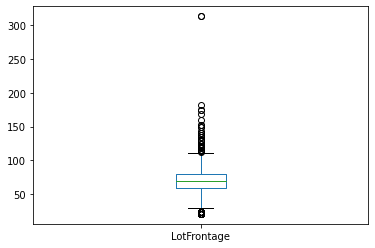

In [12]:
data['LotFrontage'].plot.box()
# => let's replace nan with median value

In [13]:
# median value
med_LotFrontage = data['LotFrontage'].quantile(0.5)
print(med_LotFrontage)

# replace null values with median
data['LotFrontage'].fillna(med_LotFrontage, inplace=True)

# how many isnull values do we now have (hopefully, zero)
data['LotFrontage'].isnull().sum()

69.0


/home/bkotryna/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


0

In [14]:
data['LotFrontage'].describe()

count    1460.000000
mean       69.863699
std        22.027677
min        21.000000
25%        60.000000
50%        69.000000
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64

### MasVnrArea
Masonry veneer area in square feet

In [15]:
curr_column = 'MasVnrArea'

display(data[curr_column].describe())

# how many null values we have
print("Number of null values in {} is {}.".format(curr_column, data[curr_column].isnull().sum()))

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

Number of null values in MasVnrArea is 8.


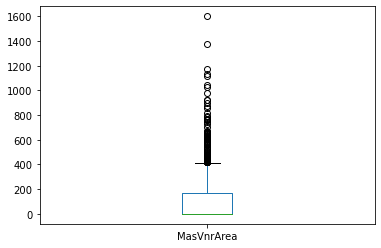

In [16]:
data[curr_column].plot.box()
# => replace nan with median value

In [17]:
# median value
med_value = data[curr_column].quantile(0.5)
print(med_value)

# replace null values with median
data[curr_column].fillna(med_value, inplace=True)

# how many isnull values do we now have (hopefully, zero)
data[curr_column].isnull().sum()

0.0


/home/bkotryna/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


0

### GarageYrBlt

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

Number of null values in GarageYrBlt is 81.


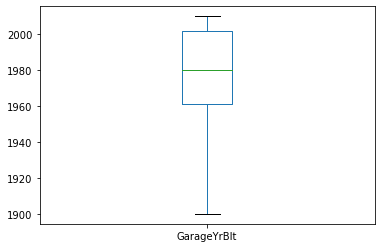

In [18]:
curr_column = 'GarageYrBlt'

display(data[curr_column].describe())

# how many null values we have
print("Number of null values in {} is {}.".format(curr_column, data[curr_column].isnull().sum()))

data[curr_column].plot.box()

In [19]:
# => could do either mean or median.
# let's repeat previous approach & replace nan with median value

# median value
med_value = data[curr_column].quantile(0.5)
print(med_value)

# replace null values with median
data[curr_column].fillna(med_value, inplace=True)

# how many isnull values do we now have (hopefully, zero)
data[curr_column].isnull().sum()

1980.0


/home/bkotryna/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


0

# Deal with null values in non-numeric columns

In [20]:
display(data["MasVnrType"].describe())
display(data["MasVnrType"].head())

count     1452
unique       4
top       None
freq       864
Name: MasVnrType, dtype: object

0    BrkFace
1       None
2    BrkFace
3       None
4    BrkFace
Name: MasVnrType, dtype: object

In [21]:
# get a list of "object" datatype columns that contain nan

# select "object" columns
data_obj = data.select_dtypes(include=object)
display(data_obj.info())

# list of columns that have nan
obj_cols_with_nan = data_obj.columns[data_obj.isna().any()].tolist()
display(obj_cols_with_nan)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   LotShape       1460 non-null   object
 3   LandContour    1460 non-null   object
 4   Utilities      1460 non-null   object
 5   LotConfig      1460 non-null   object
 6   LandSlope      1460 non-null   object
 7   Neighborhood   1460 non-null   object
 8   Condition1     1460 non-null   object
 9   Condition2     1460 non-null   object
 10  BldgType       1460 non-null   object
 11  HouseStyle     1460 non-null   object
 12  RoofStyle      1460 non-null   object
 13  RoofMatl       1460 non-null   object
 14  Exterior1st    1460 non-null   object
 15  Exterior2nd    1460 non-null   object
 16  MasVnrType     1452 non-null   object
 17  ExterQual      1460 non-null   object
 18  ExterCond      1460 non-null

None

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

### MasVnrType

In [22]:
# check out the first item from the "has nan" column list
curr_column = obj_cols_with_nan[0]
display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))
# => Obs! There clearly are missing values that don't come up as "null" in pandas!
# => I'd check ALL "object" columns for value_counts() to catch all missing values

# how many null values we have
print("Number of null values in {} is {}.".format(curr_column, data[curr_column].isnull().sum()))

count     1452
unique       4
top       None
freq       864
Name: MasVnrType, dtype: object

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

Number of null values in MasVnrType is 8.


In [23]:
# => too many None / nan values => drop this column
data.drop(curr_column, axis=1, inplace=True)

# update data_obj (not a great way of handling this whole dropping business, Im)
data_obj = data.select_dtypes(include=object)
display(data_obj.info())

/home/bkotryna/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   LotShape       1460 non-null   object
 3   LandContour    1460 non-null   object
 4   Utilities      1460 non-null   object
 5   LotConfig      1460 non-null   object
 6   LandSlope      1460 non-null   object
 7   Neighborhood   1460 non-null   object
 8   Condition1     1460 non-null   object
 9   Condition2     1460 non-null   object
 10  BldgType       1460 non-null   object
 11  HouseStyle     1460 non-null   object
 12  RoofStyle      1460 non-null   object
 13  RoofMatl       1460 non-null   object
 14  Exterior1st    1460 non-null   object
 15  Exterior2nd    1460 non-null   object
 16  ExterQual      1460 non-null   object
 17  ExterCond      1460 non-null   object
 18  Foundation     1460 non-null

None

### BsmtQual
Height of the basement

In [24]:
curr_column = obj_cols_with_nan[1]
display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))

# how many null values we have
print("Number of null values in {} is {}.".format(curr_column, data[curr_column].isnull().sum()))

count     1423
unique       4
top         TA
freq       649
Name: BsmtQual, dtype: object

array(['Gd', 'TA', 'Ex', nan, 'Fa'], dtype=object)

TA     649
Gd     618
Ex     121
NaN     37
Fa      35
Name: BsmtQual, dtype: int64

Number of null values in BsmtQual is 37.


In [25]:
# => what shall we do here?
# => let's improvise and replace nan values with the most prevalent value, ie TA

top_value = data[curr_column].value_counts(dropna=False).index.tolist()[0]
top_count = data[curr_column].value_counts(dropna=False).tolist()[0]
print("Most frequent value is '{}' and it appears {} times.".format(top_value, top_count))

Most frequent value is 'TA' and it appears 649 times.


In [26]:
data[curr_column].fillna(top_value, inplace=True)

display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))

count     1460
unique       4
top         TA
freq       686
Name: BsmtQual, dtype: object

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

TA    686
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

### BsmtCond
General condition of the basement

In [27]:
curr_column = obj_cols_with_nan[2]
display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))

# how many null values we have
print("Number of null values in {} is {}.".format(curr_column, data[curr_column].isnull().sum()))

count     1423
unique       4
top         TA
freq      1311
Name: BsmtCond, dtype: object

array(['TA', 'Gd', nan, 'Fa', 'Po'], dtype=object)

TA     1311
Gd       65
Fa       45
NaN      37
Po        2
Name: BsmtCond, dtype: int64

Number of null values in BsmtCond is 37.


In [28]:
# the most prevalent value is really common. Feels quite safe to replace nan values with it

top_value = data[curr_column].value_counts(dropna=False).index.tolist()[0]
top_count = data[curr_column].value_counts(dropna=False).tolist()[0]
print("Most frequent value is '{}' and it appears {} times.".format(top_value, top_count))

Most frequent value is 'TA' and it appears 1311 times.


In [29]:
data[curr_column].fillna(top_value, inplace=True)

display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))

count     1460
unique       4
top         TA
freq      1348
Name: BsmtCond, dtype: object

array(['TA', 'Gd', 'Fa', 'Po'], dtype=object)

TA    1348
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

### BsmtExposure
Walkout or garden level basement walls

In [30]:
curr_column = obj_cols_with_nan[3]
display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))

# how many null values we have
print("Number of null values in {} is {}.".format(curr_column, data[curr_column].isnull().sum()))

count     1422
unique       4
top         No
freq       953
Name: BsmtExposure, dtype: object

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

No     953
Av     221
Gd     134
Mn     114
NaN     38
Name: BsmtExposure, dtype: int64

Number of null values in BsmtExposure is 38.


In [31]:
# the most prevalent value is quite common. Feels quite safe to replace nan values with it

top_value = data[curr_column].value_counts(dropna=False).index.tolist()[0]
top_count = data[curr_column].value_counts(dropna=False).tolist()[0]
print("Most frequent value is '{}' and it appears {} times.".format(top_value, top_count))

data[curr_column].fillna(top_value, inplace=True)

display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))

Most frequent value is 'No' and it appears 953 times.


count     1460
unique       4
top         No
freq       991
Name: BsmtExposure, dtype: object

array(['No', 'Gd', 'Mn', 'Av'], dtype=object)

No    991
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

### BsmtFinType1
Quality of basement finished area

In [32]:
curr_column = obj_cols_with_nan[4]
display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))

# how many null values we have
print("Number of null values in {} is {}.".format(curr_column, data[curr_column].isnull().sum()))

count     1423
unique       6
top        Unf
freq       430
Name: BsmtFinType1, dtype: object

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', nan, 'LwQ'], dtype=object)

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NaN     37
Name: BsmtFinType1, dtype: int64

Number of null values in BsmtFinType1 is 37.


In [33]:
# the most prevalent value is not majorly frequent Oh well, let's replace nan values with it anyway

top_value = data[curr_column].value_counts(dropna=False).index.tolist()[0]
top_count = data[curr_column].value_counts(dropna=False).tolist()[0]
print("Most frequent value is '{}' and it appears {} times.".format(top_value, top_count))

data[curr_column].fillna(top_value, inplace=True)

display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))

Most frequent value is 'Unf' and it appears 430 times.


count     1460
unique       6
top        Unf
freq       467
Name: BsmtFinType1, dtype: object

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'LwQ'], dtype=object)

Unf    467
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

### BsmtFinType2
Quality of second finished area (if present)

In [34]:
curr_column = obj_cols_with_nan[5]
display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))

# how many null values we have
print("Number of null values in {} is {}.".format(curr_column, data[curr_column].isnull().sum()))

count     1422
unique       6
top        Unf
freq      1256
Name: BsmtFinType2, dtype: object

array(['Unf', 'BLQ', nan, 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

Unf    1256
Rec      54
LwQ      46
NaN      38
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

Number of null values in BsmtFinType2 is 38.


In [35]:
# the most prevalent value is very common. Feels very safe to replace nan values with it

top_value = data[curr_column].value_counts(dropna=False).index.tolist()[0]
top_count = data[curr_column].value_counts(dropna=False).tolist()[0]
print("Most frequent value is '{}' and it appears {} times.".format(top_value, top_count))

data[curr_column].fillna(top_value, inplace=True)

display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))

Most frequent value is 'Unf' and it appears 1256 times.


count     1460
unique       6
top        Unf
freq      1294
Name: BsmtFinType2, dtype: object

array(['Unf', 'BLQ', 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

Unf    1294
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

### Electrical

In [36]:
curr_column = obj_cols_with_nan[6]
display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))

# how many null values we have
print("Number of null values in {} is {}.".format(curr_column, data[curr_column].isnull().sum()))

count      1459
unique        5
top       SBrkr
freq       1334
Name: Electrical, dtype: object

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

Number of null values in Electrical is 1.


In [37]:
# the most prevalent value is very common. Feels very safe to replace nan values with it

top_value = data[curr_column].value_counts(dropna=False).index.tolist()[0]
top_count = data[curr_column].value_counts(dropna=False).tolist()[0]
print("Most frequent value is '{}' and it appears {} times. That is {:.0f}% of the time".format(top_value, top_count, top_count/len(data)))

data[curr_column].fillna(top_value, inplace=True)

display(data[curr_column].describe())
display(data[curr_column].unique())
display(data[curr_column].value_counts(dropna=False))

Most frequent value is 'SBrkr' and it appears 1334 times. That is 1% of the time


count      1460
unique        5
top       SBrkr
freq       1335
Name: Electrical, dtype: object

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [38]:
print("Most frequent value is '{}' and it appears {} times. That is {:.0f} % of the time".format(top_value, top_count, top_count/len(data)*100))

Most frequent value is 'SBrkr' and it appears 1334 times. That is 91 % of the time


## Boom, define functions to handle "object" columns with null values...

In [39]:
def check_obj_column(n):

    curr_column = obj_cols_with_nan[n]
    display(data[curr_column].describe())
    display(data[curr_column].unique())
    display(data[curr_column].value_counts(dropna=False))

    # how many null values we have
    print("Number of null values in {} is {}.".format(curr_column, data[curr_column].isnull().sum()))
    
    top_value = data[curr_column].value_counts(dropna=False).index.tolist()[0]
    top_count = data[curr_column].value_counts(dropna=False).tolist()[0]
    print("Most frequent value is '{}' and it appears {} times. That is {:.0f}% of the time.".format(
        top_value, top_count, top_count/len(data)*100))

In [40]:
def replace_obj_nan_with_top_value(n):
    # the most prevalent value is very common. Feels very safe to replace nan values with it

    curr_column = obj_cols_with_nan[n]
    top_value = data[curr_column].value_counts(dropna=False).index.tolist()[0]
    
    data[curr_column].fillna(top_value, inplace=True)

    display(data[curr_column].describe())
    display(data[curr_column].unique())
    display(data[curr_column].value_counts(dropna=False))

## ... then use these functions to go through null values in non-numeric columns quicker

In [41]:
check_obj_column(7)

count       1379
unique         6
top       Attchd
freq         870
Name: GarageType, dtype: object

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', nan, 'Basment', '2Types'],
      dtype=object)

Attchd     870
Detchd     387
BuiltIn     88
NaN         81
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

Number of null values in GarageType is 81.
Most frequent value is 'Attchd' and it appears 870 times. That is 60% of the time.


In [42]:
replace_obj_nan_with_top_value(7)

count       1460
unique         6
top       Attchd
freq         951
Name: GarageType, dtype: object

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'Basment', '2Types'],
      dtype=object)

Attchd     951
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

In [43]:
check_obj_column(8)

count     1379
unique       3
top        Unf
freq       605
Name: GarageFinish, dtype: object

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

Unf    605
RFn    422
Fin    352
NaN     81
Name: GarageFinish, dtype: int64

Number of null values in GarageFinish is 81.
Most frequent value is 'Unf' and it appears 605 times. That is 41% of the time.


In [44]:
replace_obj_nan_with_top_value(8)

count     1460
unique       3
top        Unf
freq       686
Name: GarageFinish, dtype: object

array(['RFn', 'Unf', 'Fin'], dtype=object)

Unf    686
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

In [45]:
check_obj_column(9)

count     1379
unique       5
top         TA
freq      1311
Name: GarageQual, dtype: object

array(['TA', 'Fa', 'Gd', nan, 'Ex', 'Po'], dtype=object)

TA     1311
NaN      81
Fa       48
Gd       14
Po        3
Ex        3
Name: GarageQual, dtype: int64

Number of null values in GarageQual is 81.
Most frequent value is 'TA' and it appears 1311 times. That is 90% of the time.


In [46]:
replace_obj_nan_with_top_value(9)

count     1460
unique       5
top         TA
freq      1392
Name: GarageQual, dtype: object

array(['TA', 'Fa', 'Gd', 'Ex', 'Po'], dtype=object)

TA    1392
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

In [47]:
check_obj_column(10)

count     1379
unique       5
top         TA
freq      1326
Name: GarageCond, dtype: object

array(['TA', 'Fa', nan, 'Gd', 'Po', 'Ex'], dtype=object)

TA     1326
NaN      81
Fa       35
Gd        9
Po        7
Ex        2
Name: GarageCond, dtype: int64

Number of null values in GarageCond is 81.
Most frequent value is 'TA' and it appears 1326 times. That is 91% of the time.


In [48]:
replace_obj_nan_with_top_value(10)

count     1460
unique       5
top         TA
freq      1407
Name: GarageCond, dtype: object

array(['TA', 'Fa', 'Gd', 'Po', 'Ex'], dtype=object)

TA    1407
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

Now that we're done replacing "object" columns that officially have nan, let's inspect ALL "object" columns <br>
(just to be sure they're not hiding any missing values (eg as "missing" rather than actual NaN))

In [49]:
def check_any_column(curr_column):

    display(data[curr_column].describe())
    display(data[curr_column].unique())
    display(data[curr_column].value_counts(dropna=False))

#     how many null values we have
#     print("Number of null values in {} is {}.".format(curr_column, data[curr_column].isnull().sum()))

In [50]:
data_obj = data.select_dtypes(include=object)
print("Number of columns to check is {}.\n\n".format(len(data_obj.columns)))

print("*** Let's loop ***\n\n")
i = 0
for curr_column in data_obj.columns.tolist():
    print("Information for column number {} is below:".format(i))
    check_any_column(curr_column)
    i += 1

Number of columns to check is 37.


*** Let's loop ***


Information for column number 0 is below:


count     1460
unique       5
top         RL
freq      1151
Name: MSZoning, dtype: object

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Information for column number 1 is below:


count     1460
unique       2
top       Pave
freq      1454
Name: Street, dtype: object

array(['Pave', 'Grvl'], dtype=object)

Pave    1454
Grvl       6
Name: Street, dtype: int64

Information for column number 2 is below:


count     1460
unique       4
top        Reg
freq       925
Name: LotShape, dtype: object

array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object)

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

Information for column number 3 is below:


count     1460
unique       4
top        Lvl
freq      1311
Name: LandContour, dtype: object

array(['Lvl', 'Bnk', 'Low', 'HLS'], dtype=object)

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

Information for column number 4 is below:


count       1460
unique         2
top       AllPub
freq        1459
Name: Utilities, dtype: object

array(['AllPub', 'NoSeWa'], dtype=object)

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Information for column number 5 is below:


count       1460
unique         5
top       Inside
freq        1052
Name: LotConfig, dtype: object

array(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], dtype=object)

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Information for column number 6 is below:


count     1460
unique       3
top        Gtl
freq      1382
Name: LandSlope, dtype: object

array(['Gtl', 'Mod', 'Sev'], dtype=object)

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Information for column number 7 is below:


count      1460
unique       25
top       NAmes
freq        225
Name: Neighborhood, dtype: object

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

Information for column number 8 is below:


count     1460
unique       9
top       Norm
freq      1260
Name: Condition1, dtype: object

array(['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA',
       'RRNe'], dtype=object)

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

Information for column number 9 is below:


count     1460
unique       8
top       Norm
freq      1445
Name: Condition2, dtype: object

array(['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'],
      dtype=object)

Norm      1445
Feedr        6
Artery       2
PosN         2
RRNn         2
RRAn         1
PosA         1
RRAe         1
Name: Condition2, dtype: int64

Information for column number 10 is below:


count     1460
unique       5
top       1Fam
freq      1220
Name: BldgType, dtype: object

array(['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], dtype=object)

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

Information for column number 11 is below:


count       1460
unique         8
top       1Story
freq         726
Name: HouseStyle, dtype: object

array(['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf',
       '2.5Fin'], dtype=object)

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

Information for column number 12 is below:


count      1460
unique        6
top       Gable
freq       1141
Name: RoofStyle, dtype: object

array(['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], dtype=object)

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

Information for column number 13 is below:


count        1460
unique          8
top       CompShg
freq         1434
Name: RoofMatl, dtype: object

array(['CompShg', 'WdShngl', 'Metal', 'WdShake', 'Membran', 'Tar&Grv',
       'Roll', 'ClyTile'], dtype=object)

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Roll          1
Membran       1
Metal         1
Name: RoofMatl, dtype: int64

Information for column number 14 is below:


count        1460
unique         15
top       VinylSd
freq          515
Name: Exterior1st, dtype: object

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
ImStucc      1
CBlock       1
AsphShn      1
Name: Exterior1st, dtype: int64

Information for column number 15 is below:


count        1460
unique         16
top       VinylSd
freq          504
Name: Exterior2nd, dtype: object

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64

Information for column number 16 is below:


count     1460
unique       4
top         TA
freq       906
Name: ExterQual, dtype: object

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

Information for column number 17 is below:


count     1460
unique       5
top         TA
freq      1282
Name: ExterCond, dtype: object

array(['TA', 'Gd', 'Fa', 'Po', 'Ex'], dtype=object)

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

Information for column number 18 is below:


count      1460
unique        6
top       PConc
freq        647
Name: Foundation, dtype: object

array(['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'], dtype=object)

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

Information for column number 19 is below:


count     1460
unique       4
top         TA
freq       686
Name: BsmtQual, dtype: object

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

TA    686
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

Information for column number 20 is below:


count     1460
unique       4
top         TA
freq      1348
Name: BsmtCond, dtype: object

array(['TA', 'Gd', 'Fa', 'Po'], dtype=object)

TA    1348
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

Information for column number 21 is below:


count     1460
unique       4
top         No
freq       991
Name: BsmtExposure, dtype: object

array(['No', 'Gd', 'Mn', 'Av'], dtype=object)

No    991
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

Information for column number 22 is below:


count     1460
unique       6
top        Unf
freq       467
Name: BsmtFinType1, dtype: object

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'LwQ'], dtype=object)

Unf    467
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

Information for column number 23 is below:


count     1460
unique       6
top        Unf
freq      1294
Name: BsmtFinType2, dtype: object

array(['Unf', 'BLQ', 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

Unf    1294
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

Information for column number 24 is below:


count     1460
unique       6
top       GasA
freq      1428
Name: Heating, dtype: object

array(['GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'], dtype=object)

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

Information for column number 25 is below:


count     1460
unique       5
top         Ex
freq       741
Name: HeatingQC, dtype: object

array(['Ex', 'Gd', 'TA', 'Fa', 'Po'], dtype=object)

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

Information for column number 26 is below:


count     1460
unique       2
top          Y
freq      1365
Name: CentralAir, dtype: object

array(['Y', 'N'], dtype=object)

Y    1365
N      95
Name: CentralAir, dtype: int64

Information for column number 27 is below:


count      1460
unique        5
top       SBrkr
freq       1335
Name: Electrical, dtype: object

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Information for column number 28 is below:


count     1460
unique       4
top         TA
freq       735
Name: KitchenQual, dtype: object

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

Information for column number 29 is below:


count     1460
unique       7
top        Typ
freq      1360
Name: Functional, dtype: object

array(['Typ', 'Min1', 'Maj1', 'Min2', 'Mod', 'Maj2', 'Sev'], dtype=object)

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

Information for column number 30 is below:


count       1460
unique         6
top       Attchd
freq         951
Name: GarageType, dtype: object

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'Basment', '2Types'],
      dtype=object)

Attchd     951
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

Information for column number 31 is below:


count     1460
unique       3
top        Unf
freq       686
Name: GarageFinish, dtype: object

array(['RFn', 'Unf', 'Fin'], dtype=object)

Unf    686
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

Information for column number 32 is below:


count     1460
unique       5
top         TA
freq      1392
Name: GarageQual, dtype: object

array(['TA', 'Fa', 'Gd', 'Ex', 'Po'], dtype=object)

TA    1392
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

Information for column number 33 is below:


count     1460
unique       5
top         TA
freq      1407
Name: GarageCond, dtype: object

array(['TA', 'Fa', 'Gd', 'Po', 'Ex'], dtype=object)

TA    1407
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

Information for column number 34 is below:


count     1460
unique       3
top          Y
freq      1340
Name: PavedDrive, dtype: object

array(['Y', 'N', 'P'], dtype=object)

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

Information for column number 35 is below:


count     1460
unique       9
top         WD
freq      1267
Name: SaleType, dtype: object

array(['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth'],
      dtype=object)

WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

Information for column number 36 is below:


count       1460
unique         6
top       Normal
freq        1198
Name: SaleCondition, dtype: object

array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
      dtype=object)

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

=>
* all seem good and not hiding missing values
* yay, Ig

## Let's inspect numeric data

In [51]:
data_num = data.select_dtypes(include=np.number)
print("Number of columns to check is {}.\n\n".format(len(data_num.columns)))

print("*** Let's loop ***\n\n")
i = 0
for curr_column in data_num.columns.tolist():
    print("Information for column number {} is below:".format(i))
    check_any_column(curr_column)
    i += 1

Number of columns to check is 38.


*** Let's loop ***


Information for column number 0 is below:


count    1460.000000
mean      730.500000
std       421.610009
min         1.000000
25%       365.750000
50%       730.500000
75%      1095.250000
max      1460.000000
Name: Id, dtype: float64

array([   1,    2,    3, ..., 1458, 1459, 1460])

1460    1
479     1
481     1
482     1
483     1
       ..
976     1
977     1
978     1
979     1
1       1
Name: Id, Length: 1460, dtype: int64

Information for column number 1 is below:


count    1460.000000
mean       56.897260
std        42.300571
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40])

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

Information for column number 2 is below:


count    1460.000000
mean       69.863699
std        22.027677
min        21.000000
25%        60.000000
50%        69.000000
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  69.,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,  77.,
        64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,  92.,
       134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,  67.,
        83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,  87.,
       116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,  38.,
       109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144., 114.,
       128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,  46.])

69.0     270
60.0     143
70.0      70
80.0      69
50.0      57
        ... 
33.0       1
38.0       1
138.0      1
140.0      1
137.0      1
Name: LotFrontage, Length: 110, dtype: int64

Information for column number 3 is below:


count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

array([ 8450,  9600, 11250, ..., 17217, 13175,  9717])

7200     25
9600     24
6000     17
10800    14
9000     14
         ..
7094      1
6130      1
9337      1
5232      1
8190      1
Name: LotArea, Length: 1073, dtype: int64

Information for column number 4 is below:


count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

Information for column number 5 is below:


count    1460.000000
mean        5.575342
std         1.112799
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64

array([5, 8, 6, 7, 4, 2, 3, 9, 1])

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

Information for column number 6 is below:


count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

array([2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939, 1965,
       2005, 1962, 2006, 1960, 1929, 1970, 1967, 1958, 1930, 2002, 1968,
       2007, 1951, 1957, 1927, 1920, 1966, 1959, 1994, 1954, 1953, 1955,
       1983, 1975, 1997, 1934, 1963, 1981, 1964, 1999, 1972, 1921, 1945,
       1982, 1998, 1956, 1948, 1910, 1995, 1991, 2009, 1950, 1961, 1977,
       1985, 1979, 1885, 1919, 1990, 1969, 1935, 1988, 1971, 1952, 1936,
       1923, 1924, 1984, 1926, 1940, 1941, 1987, 1986, 2008, 1908, 1892,
       1916, 1932, 1918, 1912, 1947, 1925, 1900, 1980, 1989, 1992, 1949,
       1880, 1928, 1978, 1922, 1996, 2010, 1946, 1913, 1937, 1942, 1938,
       1974, 1893, 1914, 1906, 1890, 1898, 1904, 1882, 1875, 1911, 1917,
       1872, 1905])

2006    67
2005    64
2004    54
2007    49
2003    45
        ..
1906     1
1911     1
1913     1
1917     1
1872     1
Name: YearBuilt, Length: 112, dtype: int64

Information for column number 7 is below:


count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

array([2003, 1976, 2002, 1970, 2000, 1995, 2005, 1973, 1950, 1965, 2006,
       1962, 2007, 1960, 2001, 1967, 2004, 2008, 1997, 1959, 1990, 1955,
       1983, 1980, 1966, 1963, 1987, 1964, 1972, 1996, 1998, 1989, 1953,
       1956, 1968, 1981, 1992, 2009, 1982, 1961, 1993, 1999, 1985, 1979,
       1977, 1969, 1958, 1991, 1971, 1952, 1975, 2010, 1984, 1986, 1994,
       1988, 1954, 1957, 1951, 1978, 1974])

1950    178
2006     97
2007     76
2005     73
2004     62
       ... 
2010      6
1983      5
1952      5
1986      5
1951      4
Name: YearRemodAdd, Length: 61, dtype: int64

Information for column number 8 is below:


count    1460.000000
mean      103.117123
std       180.731373
min         0.000000
25%         0.000000
50%         0.000000
75%       164.250000
max      1600.000000
Name: MasVnrArea, dtype: float64

array([1.960e+02, 0.000e+00, 1.620e+02, 3.500e+02, 1.860e+02, 2.400e+02,
       2.860e+02, 3.060e+02, 2.120e+02, 1.800e+02, 3.800e+02, 2.810e+02,
       6.400e+02, 2.000e+02, 2.460e+02, 1.320e+02, 6.500e+02, 1.010e+02,
       4.120e+02, 2.720e+02, 4.560e+02, 1.031e+03, 1.780e+02, 5.730e+02,
       3.440e+02, 2.870e+02, 1.670e+02, 1.115e+03, 4.000e+01, 1.040e+02,
       5.760e+02, 4.430e+02, 4.680e+02, 6.600e+01, 2.200e+01, 2.840e+02,
       7.600e+01, 2.030e+02, 6.800e+01, 1.830e+02, 4.800e+01, 2.800e+01,
       3.360e+02, 6.000e+02, 7.680e+02, 4.800e+02, 2.200e+02, 1.840e+02,
       1.129e+03, 1.160e+02, 1.350e+02, 2.660e+02, 8.500e+01, 3.090e+02,
       1.360e+02, 2.880e+02, 7.000e+01, 3.200e+02, 5.000e+01, 1.200e+02,
       4.360e+02, 2.520e+02, 8.400e+01, 6.640e+02, 2.260e+02, 3.000e+02,
       6.530e+02, 1.120e+02, 4.910e+02, 2.680e+02, 7.480e+02, 9.800e+01,
       2.750e+02, 1.380e+02, 2.050e+02, 2.620e+02, 1.280e+02, 2.600e+02,
       1.530e+02, 6.400e+01, 3.120e+02, 1.600e+01, 

0.0      869
72.0       8
180.0      8
108.0      8
120.0      7
        ... 
651.0      1
337.0      1
415.0      1
293.0      1
621.0      1
Name: MasVnrArea, Length: 327, dtype: int64

Information for column number 9 is below:


count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

array([ 706,  978,  486,  216,  655,  732, 1369,  859,    0,  851,  906,
        998,  737,  733,  578,  646,  504,  840,  188,  234, 1218, 1277,
       1018, 1153, 1213,  731,  643,  967,  747,  280,  179,  456, 1351,
         24,  763,  182,  104, 1810,  384,  490,  649,  632,  941,  739,
        912, 1013,  603, 1880,  565,  320,  462,  228,  336,  448, 1201,
         33,  588,  600,  713, 1046,  648,  310, 1162,  520,  108,  569,
       1200,  224,  705,  444,  250,  984,   35,  774,  419,  170, 1470,
        938,  570,  300,  120,  116,  512,  567,  445,  695,  405, 1005,
        668,  821,  432, 1300,  507,  679, 1332,  209,  680,  716, 1400,
        416,  429,  222,   57,  660, 1016,  370,  351,  379, 1288,  360,
        639,  495,  288, 1398,  477,  831, 1904,  436,  352,  611, 1086,
        297,  626,  560,  390,  566, 1126, 1036, 1088,  641,  617,  662,
        312, 1065,  787,  468,   36,  822,  378,  946,  341,   16,  550,
        524,   56,  321,  842,  689,  625,  358,  4

0       467
24       12
16        9
20        5
686       5
       ... 
1032      1
1022      1
599       1
1018      1
1904      1
Name: BsmtFinSF1, Length: 637, dtype: int64

Information for column number 10 is below:


count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64

array([   0,   32,  668,  486,   93,  491,  506,  712,  362,   41,  169,
        869,  150,  670,   28, 1080,  181,  768,  215,  374,  208,  441,
        184,  279,  306,  180,  580,  690,  692,  228,  125, 1063,  620,
        175,  820, 1474,  264,  479,  147,  232,  380,  544,  294,  258,
        121,  391,  531,  344,  539,  713,  210,  311, 1120,  165,  532,
         96,  495,  174, 1127,  139,  202,  645,  123,  551,  219,  606,
        612,  480,  182,  132,  336,  468,  287,   35,  499,  723,  119,
         40,  117,  239,   80,  472,   64, 1057,  127,  630,  128,  377,
        764,  345, 1085,  435,  823,  500,  290,  324,  634,  411,  841,
       1061,  466,  396,  354,  149,  193,  273,  465,  400,  682,  557,
        230,  106,  791,  240,  547,  469,  177,  108,  600,  492,  211,
        168, 1031,  438,  375,  144,   81,  906,  608,  276,  661,   68,
        173,  972,  105,  420,  546,  334,  352,  872,  110,  627,  163,
       1029])

0       1293
180        5
374        3
551        2
93         2
        ... 
532        1
544        1
546        1
547        1
1474       1
Name: BsmtFinSF2, Length: 144, dtype: int64

Information for column number 11 is below:


count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

array([ 150,  284,  434,  540,  490,   64,  317,  216,  952,  140,  134,
        177,  175, 1494,  520,  832,  426,    0,  468,  525, 1158,  637,
       1777,  200,  204, 1566,  180,  486,  207,  649, 1228, 1234,  380,
        408, 1117, 1097,   84,  326,  445,  383,  167,  465, 1296,   83,
       1632,  736,  192,  612,  816,   32,  935,  321,  860, 1410,  148,
        217,  530, 1346,  576,  318, 1143, 1035,  440,  747,  701,  343,
        280,  404,  840,  724,  295, 1768,  448,   36, 1530, 1065,  384,
       1288,  684, 1013,  402,  635,  163,  168,  176,  370,  350,  381,
        410,  741, 1226, 1053,  641,  516,  793, 1139,  550,  905,  104,
        310,  252, 1125,  203,  728,  732,  510,  899, 1362,   30,  958,
        556,  413,  479,  297,  658,  262,  891, 1304,  519, 1907,  336,
        107,  432,  403,  811,  396,  970,  506,  884,  400,  896,  253,
        409,   93, 1200,  572,  774,  769, 1335,  340,  882,  779,  112,
        470,  294, 1686,  360,  441,  354,  700,  7

0       118
728       9
384       8
572       7
600       7
       ... 
731       1
730       1
726       1
725       1
2046      1
Name: BsmtUnfSF, Length: 780, dtype: int64

Information for column number 12 is below:


count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

array([ 856, 1262,  920,  756, 1145,  796, 1686, 1107,  952,  991, 1040,
       1175,  912, 1494, 1253,  832, 1004,    0, 1114, 1029, 1158,  637,
       1777, 1060, 1566,  900, 1704, 1484,  520,  649, 1228, 1234, 1398,
       1561, 1117, 1097, 1297, 1057, 1088, 1350,  840,  938, 1150, 1752,
       1434, 1656,  736,  955,  794,  816, 1842,  384, 1425,  970,  860,
       1410,  780,  530, 1370,  576, 1143, 1947, 1453,  747, 1304, 2223,
        845, 1086,  462,  672, 1768,  440,  896, 1237, 1563, 1065, 1288,
        684,  612, 1013,  990, 1235,  876, 1214,  824,  680, 1588,  960,
        458,  950, 1610,  741, 1226, 1053,  641,  789,  793, 1844,  994,
       1264, 1809, 1028,  729, 1092, 1125, 1673,  728,  732, 1080, 1199,
       1362, 1078,  660, 1008,  924,  992, 1063, 1267, 1461, 1907,  928,
        864, 1734,  910, 1490, 1728,  715,  884,  969, 1710,  825, 1602,
       1200,  572,  774, 1392, 1232, 1572, 1541,  882, 1149,  644, 1617,
       1582,  720, 1064, 1606, 1202, 1151, 1052, 22

0       37
864     35
672     17
912     15
1040    14
        ..
1463     1
1459     1
1454     1
1019     1
2046     1
Name: TotalBsmtSF, Length: 721, dtype: int64

Information for column number 13 is below:


count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

array([ 856, 1262,  920,  961, 1145,  796, 1694, 1107, 1022, 1077, 1040,
       1182,  912, 1494, 1253,  854, 1004, 1296, 1114, 1339, 1158, 1108,
       1795, 1060, 1600,  900, 1704,  520,  649, 1228, 1234, 1700, 1561,
       1132, 1097, 1297, 1057, 1152, 1324, 1328,  884,  938, 1150, 1752,
       1518, 1656,  736,  955,  794,  816, 1842, 1360, 1425,  983,  860,
       1426,  780,  581, 1370,  902, 1143, 2207, 1479,  747, 1304, 2223,
        845,  885, 1086,  840,  526,  952, 1072, 1768,  682, 1337, 1563,
       1065,  804, 1301,  684,  612, 1013,  990, 1235,  964, 1260,  905,
        680, 1588,  960,  835, 1225, 1610,  977, 1535, 1226, 1053, 1047,
        789,  997, 1844, 1216,  774, 1282, 2259, 1436,  729, 1092, 1125,
       1699,  728,  988,  772, 1080, 1199, 1586,  958,  660, 1327, 1721,
       1682, 1214, 1959,  928,  864, 1734,  910, 1501, 1728,  970,  875,
        896,  969, 1710, 1252, 1200,  572,  991, 1392, 1232, 1572, 1541,
        882, 1149,  808, 1867, 1707, 1064, 1362, 16

864     25
1040    16
912     14
848     12
894     12
        ..
1285     1
1287     1
1288     1
1297     1
2053     1
Name: 1stFlrSF, Length: 753, dtype: int64

Information for column number 14 is below:


count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

array([ 854,    0,  866,  756, 1053,  566,  983,  752, 1142, 1218,  668,
       1320,  631,  716,  676,  860, 1519,  530,  808,  977, 1330,  833,
        765,  462,  213,  548,  960,  670, 1116,  876,  612, 1031,  881,
        790,  755,  592,  939,  520,  639,  656, 1414,  884,  729, 1523,
        728,  351,  688,  941, 1032,  848,  836,  475,  739, 1151,  448,
        896,  524, 1194,  956, 1070, 1096,  467,  547,  551,  880,  703,
        901,  720,  316, 1518,  704, 1178,  754,  601, 1360,  929,  445,
        564,  882,  920,  518,  817, 1257,  741,  672, 1306,  504, 1304,
       1100,  730,  689,  591,  888, 1020,  828,  700,  842, 1286,  864,
        829, 1092,  709,  844, 1106,  596,  807,  625,  649,  698,  840,
        780,  568,  795,  648,  975,  702, 1242, 1818, 1121,  371,  804,
        325,  809, 1200,  871, 1274, 1347, 1332, 1177, 1080,  695,  167,
        915,  576,  605,  862,  495,  403,  838,  517, 1427,  784,  711,
        468, 1081,  886,  793,  665,  858,  874,  5

0       829
728      10
504       9
672       8
546       8
       ... 
788       1
1116      1
1112      1
1111      1
1872      1
Name: 2ndFlrSF, Length: 417, dtype: int64

Information for column number 15 is below:


count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64

array([  0, 360, 513, 234, 528, 572, 144, 392, 371, 390, 420, 473, 156,
       515,  80,  53, 232, 481, 120, 514, 397, 479, 205, 384])

0      1434
80        3
360       2
528       1
53        1
120       1
144       1
156       1
205       1
232       1
234       1
371       1
572       1
390       1
392       1
397       1
420       1
473       1
479       1
481       1
513       1
514       1
515       1
384       1
Name: LowQualFinSF, dtype: int64

Information for column number 16 is below:


count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

array([1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077, 1040,
       2324,  912, 1494, 1253,  854, 1004, 1296, 1114, 1339, 2376, 1108,
       1795, 1060, 1600,  900, 1704,  520, 1317, 1228, 1234, 1700, 1561,
       2452, 1097, 1297, 1057, 1152, 1324, 1328,  884,  938, 1150, 1752,
       2149, 1656, 1452,  955, 1470, 1176,  816, 1842, 1360, 1425, 1739,
       1720, 2945,  780, 1158, 1111, 1370, 2034, 2473, 2207, 1479,  747,
       2287, 2223,  845, 1718, 1086, 1605,  988,  952, 1285, 1768, 1230,
       2142, 1337, 1563, 1065, 1474, 2417, 1560, 1224, 1526,  990, 1235,
        964, 2291, 1588,  960,  835, 1225, 1610, 1732, 1535, 1226, 1818,
       1992, 1047,  789, 1517, 1844, 1855, 1430, 2696, 2259, 2320, 1458,
       1092, 1125, 3222, 1456, 1123, 1080, 1199, 1586,  754,  958,  840,
       1348, 1053, 2157, 2054, 1327, 1721, 1682, 1214, 1959, 1852, 1764,
        864, 1734, 1385, 1501, 1728, 1709,  875, 2035, 1344,  969, 1993,
       1252, 1200, 1096, 1968, 1947, 2462, 1232, 26

864     22
1040    14
894     11
848     10
1456    10
        ..
3447     1
1396     1
1395     1
1393     1
2054     1
Name: GrLivArea, Length: 861, dtype: int64

Information for column number 17 is below:


count    1460.000000
mean        0.425342
std         0.518911
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64

array([1, 0, 2, 3])

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

Information for column number 18 is below:


count    1460.000000
mean        0.057534
std         0.238753
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64

array([0, 1, 2])

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

Information for column number 19 is below:


count    1460.000000
mean        1.565068
std         0.550916
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64

array([2, 1, 3, 0])

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

Information for column number 20 is below:


count    1460.000000
mean        0.382877
std         0.502885
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: HalfBath, dtype: float64

array([1, 0, 2])

0    913
1    535
2     12
Name: HalfBath, dtype: int64

Information for column number 21 is below:


count    1460.000000
mean        2.866438
std         0.815778
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: BedroomAbvGr, dtype: float64

array([3, 4, 1, 2, 0, 5, 6, 8])

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

Information for column number 22 is below:


count    1460.000000
mean        1.046575
std         0.220338
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64

array([1, 2, 3, 0])

1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

Information for column number 23 is below:


count    1460.000000
mean        6.517808
std         1.625393
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: TotRmsAbvGrd, dtype: float64

array([ 8,  6,  7,  9,  5, 11,  4, 10, 12,  3,  2, 14])

6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     18
3      17
12     11
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64

Information for column number 24 is below:


count    1460.000000
mean        0.613014
std         0.644666
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Fireplaces, dtype: float64

array([0, 1, 2, 3])

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

Information for column number 25 is below:


count    1460.000000
mean     1978.589041
std        23.997022
min      1900.000000
25%      1962.000000
50%      1980.000000
75%      2001.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953., 1980., 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1924., 1996.,
       1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925., 1941.,
       2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928., 1922.,
       1934., 1906., 1914., 1946., 1908., 1929., 1933.])

1980.0    96
2005.0    65
2006.0    59
2004.0    53
2003.0    50
          ..
1900.0     1
1906.0     1
1933.0     1
1908.0     1
1927.0     1
Name: GarageYrBlt, Length: 97, dtype: int64

Information for column number 26 is below:


count    1460.000000
mean        1.767123
std         0.747315
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64

array([2, 3, 1, 0, 4])

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

Information for column number 27 is below:


count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

array([ 548,  460,  608,  642,  836,  480,  636,  484,  468,  205,  384,
        736,  352,  840,  576,  516,  294,  853,  280,  534,  572,  270,
        890,  772,  319,  240,  250,  271,  447,  556,  691,  672,  498,
        246,    0,  440,  308,  504,  300,  670,  826,  386,  388,  528,
        894,  565,  641,  288,  645,  852,  558,  220,  667,  360,  427,
        490,  379,  297,  283,  509,  405,  758,  461,  400,  462,  420,
        432,  506,  684,  472,  366,  476,  410,  740,  648,  273,  546,
        325,  792,  450,  180,  430,  594,  390,  540,  264,  530,  435,
        453,  750,  487,  624,  471,  318,  766,  660,  470,  720,  577,
        380,  434,  866,  495,  564,  312,  625,  680,  678,  726,  532,
        216,  303,  789,  511,  616,  521,  451, 1166,  252,  497,  682,
        666,  786,  795,  856,  473,  398,  500,  349,  454,  644,  299,
        210,  431,  438,  675,  968,  721,  336,  810,  494,  457,  818,
        463,  604,  389,  538,  520,  309,  429,  6

0       81
440     49
576     47
240     38
484     34
        ..
754      1
459      1
458      1
756      1
1418     1
Name: GarageArea, Length: 441, dtype: int64

Information for column number 28 is below:


count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

array([  0, 298, 192,  40, 255, 235,  90, 147, 140, 160,  48, 240, 171,
       100, 406, 222, 288,  49, 203, 113, 392, 145, 196, 168, 112, 106,
       857, 115, 120,  12, 576, 301, 144, 300,  74, 127, 232, 158, 352,
       182, 180, 166, 224,  80, 367,  53, 188, 105,  24,  98, 276, 200,
       409, 239, 400, 476, 178, 574, 237, 210, 441, 116, 280, 104,  87,
       132, 238, 149, 355,  60, 139, 108, 351, 209, 216, 248, 143, 365,
       370,  58, 197, 263, 123, 138, 333, 250, 292,  95, 262,  81, 289,
       124, 172, 110, 208, 468, 256, 302, 190, 340, 233, 184, 201, 142,
       122, 155, 670, 135, 495, 536, 306,  64, 364, 353,  66, 159, 146,
       296, 125,  44, 215, 264,  88,  89,  96, 414, 519, 206, 141, 260,
       324, 156, 220,  38, 261, 126,  85, 466, 270,  78, 169, 320, 268,
        72, 349,  42,  35, 326, 382, 161, 179, 103, 253, 148, 335, 176,
       390, 328, 312, 185, 269, 195,  57, 236, 517, 304, 198, 426,  28,
       316, 322, 307, 257, 219, 416, 344, 380,  68, 114, 327, 16

0      761
192     38
100     36
144     33
120     31
      ... 
269      1
265      1
263      1
260      1
215      1
Name: WoodDeckSF, Length: 274, dtype: int64

Information for column number 29 is below:


count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

array([ 61,   0,  42,  35,  84,  30,  57, 204,   4,  21,  33, 213, 112,
       102, 154, 159, 110,  90,  56,  32,  50, 258,  54,  65,  38,  47,
        64,  52, 138, 104,  82,  43, 146,  75,  72,  70,  49,  11,  36,
       151,  29,  94, 101, 199,  99, 234, 162,  63,  68,  46,  45, 122,
       184, 120,  20,  24, 130, 205, 108,  80,  66,  48,  25,  96, 111,
       106,  40, 114,   8, 136, 132,  62, 228,  60, 238, 260,  27,  74,
        16, 198,  26,  83,  34,  55,  22,  98, 172, 119, 208, 105, 140,
       168,  28,  39, 148,  12,  51, 150, 117, 250,  10,  81,  44, 144,
       175, 195, 128,  76,  17,  59, 214, 121,  53, 231, 134, 192, 123,
        78, 187,  85, 133, 176, 113, 137, 125, 523, 100, 285,  88, 406,
       155,  73, 182, 502, 274, 158, 142, 243, 235, 312, 124, 267, 265,
        87, 288,  23, 152, 341, 116, 160, 174, 247, 291,  18, 170, 156,
       166, 129, 418, 240,  77, 364, 188, 207,  67,  69, 131, 191,  41,
       118, 252, 189, 282, 135,  95, 224, 169, 319,  58,  93, 24

0      656
36      29
48      22
20      21
40      19
      ... 
159      1
156      1
148      1
142      1
119      1
Name: OpenPorchSF, Length: 202, dtype: int64

Information for column number 30 is below:


count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

array([  0, 272, 228, 205, 176,  87, 172, 102,  37, 144,  64, 114, 202,
       128, 156,  44,  77, 192, 140, 180, 183,  39, 184,  40, 552,  30,
       126,  96,  60, 150, 120, 112, 252,  52, 224, 234, 244, 268, 137,
        24, 108, 294, 177, 218, 242,  91, 160, 130, 169, 105,  34, 248,
       236,  32,  80, 115, 291, 116, 158, 210,  36, 200,  84, 148, 136,
       240,  54, 100, 189, 293, 164, 216, 239,  67,  90,  56, 129,  98,
       143,  70, 386, 154, 185, 134, 196, 264, 275, 230, 254,  68, 194,
       318,  48,  94, 138, 226, 174,  19, 170, 220, 214, 280, 190, 330,
       208, 145, 259,  81,  42, 123, 162, 286, 168,  20, 301, 198, 221,
       212,  50,  99])

0      1252
112      15
96        6
120       5
144       5
       ... 
174       1
177       1
183       1
189       1
552       1
Name: EnclosedPorch, Length: 120, dtype: int64

Information for column number 31 is below:


count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

array([  0, 320, 407, 130, 180, 168, 140, 508, 238, 245, 196, 144, 182,
       162,  23, 216,  96, 153, 290, 304])

0      1436
168       3
216       2
144       2
180       2
245       1
238       1
290       1
196       1
182       1
407       1
304       1
162       1
153       1
320       1
140       1
130       1
96        1
23        1
508       1
Name: 3SsnPorch, dtype: int64

Information for column number 32 is below:


count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64

array([  0, 176, 198, 291, 252,  99, 184, 168, 130, 142, 192, 410, 224,
       266, 170, 154, 153, 144, 128, 259, 160, 271, 234, 374, 185, 182,
        90, 396, 140, 276, 180, 161, 145, 200, 122,  95, 120,  60, 126,
       189, 260, 147, 385, 287, 156, 100, 216, 210, 197, 204, 225, 152,
       175, 312, 222, 265, 322, 190, 233,  63,  53, 143, 273, 288, 263,
        80, 163, 116, 480, 178, 440, 155, 220, 119, 165,  40])

0      1344
192       6
224       5
120       5
189       4
       ... 
182       1
440       1
178       1
312       1
480       1
Name: ScreenPorch, Length: 76, dtype: int64

Information for column number 33 is below:


count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

array([  0, 512, 648, 576, 555, 480, 519, 738])

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

Information for column number 34 is below:


count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

array([    0,   700,   350,   500,   400,   480,   450, 15500,  1200,
         800,  2000,   600,  3500,  1300,    54,   620,   560,  1400,
        8300,  1150,  2500])

0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54          1
Name: MiscVal, dtype: int64

Information for column number 35 is below:


count    1460.000000
mean        6.321918
std         2.703626
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        12.000000
Name: MoSold, dtype: float64

array([ 2,  5,  9, 12, 10,  8, 11,  4,  1,  7,  3,  6])

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

Information for column number 36 is below:


count    1460.000000
mean     2007.815753
std         1.328095
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64

array([2008, 2007, 2006, 2009, 2010])

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

Information for column number 37 is below:


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

array([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000,
       129900, 118000, 129500, 345000, 144000, 279500, 157000, 132000,
       149000,  90000, 159000, 139000, 325300, 139400, 230000, 154000,
       256300, 134800, 306000, 207500,  68500,  40000, 149350, 179900,
       165500, 277500, 309000, 145000, 153000, 109000,  82000, 160000,
       170000, 130250, 141000, 319900, 239686, 249700, 113000, 127000,
       177000, 114500, 110000, 385000, 130000, 180500, 172500, 196500,
       438780, 124900, 158000, 101000, 202500, 219500, 317000, 180000,
       226000,  80000, 225000, 244000, 185000, 144900, 107400,  91000,
       135750, 136500, 193500, 153500, 245000, 126500, 168500, 260000,
       174000, 164500,  85000, 123600, 109900,  98600, 163500, 133900,
       204750, 214000,  94750,  83000, 128950, 205000, 178000, 118964,
       198900, 169500, 100000, 115000, 190000, 136900, 383970, 217000,
       259500, 176000, 155000, 320000, 163990, 136000, 153900, 181000,
      

140000    20
135000    17
145000    14
155000    14
190000    13
          ..
84900      1
424870     1
415298     1
62383      1
34900      1
Name: SalePrice, Length: 663, dtype: int64

In [52]:
print(data_num.columns.tolist())

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


#### Ideas    
    
1. Create new columns with ages:
    1. AgeAtSale column (= YrSold - YearBuilt)
    1. RemodAge (= YrSold - YearRemodAdd)
    1. GarrageAge (= YrSold - GarageYrBlt)
    
  
2. Special columns that shouldn't be interpreted as plain numbers:<br>
=> let's one-hot encode them
    1. MSSubClass: The building class
    1. MoSold: Month sold


In [53]:
data['AgeAtSale'] = data['YrSold'] - data['YearBuilt']
data['RemodAge'] = data['YrSold'] - data['YearRemodAdd']
data['GarageAge'] = data['YrSold'] - data['GarageYrBlt']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

<ipython-input-53-394808c78a34>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['AgeAtSale'] = data['YrSold'] - data['YearBuilt']
<ipython-input-53-394808c78a34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RemodAge'] = data['YrSold'] - data['YearRemodAdd']
<ipython-input-53-394808c78a34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [54]:
data['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [55]:
data['MoSold'].value_counts()

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

## Let's neaten the non-numeric columns
One-hot encode

#### Let's inspect the non-numeric data

In [56]:
def check_any_column(curr_column):

    display(data[curr_column].describe())
    display(data[curr_column].unique())
    display(data[curr_column].value_counts(dropna=False))

#     how many null values we have
#     print("Number of null values in {} is {}.".format(curr_column, data[curr_column].isnull().sum()))

In [57]:
data_obj = data.select_dtypes(include=object)
print("Number of columns to check is {}.\n\n".format(len(data_obj.columns)))

print(data_obj.columns.tolist(), "\n\n")

print("*** Let's loop ***\n\n")
i = 0
for curr_column in data_obj.columns.tolist():
    print("Information for column number {} is below:".format(i))
    check_any_column(curr_column)
    i += 1

Number of columns to check is 37.


['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'] 


*** Let's loop ***


Information for column number 0 is below:


count     1460
unique       5
top         RL
freq      1151
Name: MSZoning, dtype: object

array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Information for column number 1 is below:


count     1460
unique       2
top       Pave
freq      1454
Name: Street, dtype: object

array(['Pave', 'Grvl'], dtype=object)

Pave    1454
Grvl       6
Name: Street, dtype: int64

Information for column number 2 is below:


count     1460
unique       4
top        Reg
freq       925
Name: LotShape, dtype: object

array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object)

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

Information for column number 3 is below:


count     1460
unique       4
top        Lvl
freq      1311
Name: LandContour, dtype: object

array(['Lvl', 'Bnk', 'Low', 'HLS'], dtype=object)

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

Information for column number 4 is below:


count       1460
unique         2
top       AllPub
freq        1459
Name: Utilities, dtype: object

array(['AllPub', 'NoSeWa'], dtype=object)

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Information for column number 5 is below:


count       1460
unique         5
top       Inside
freq        1052
Name: LotConfig, dtype: object

array(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], dtype=object)

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Information for column number 6 is below:


count     1460
unique       3
top        Gtl
freq      1382
Name: LandSlope, dtype: object

array(['Gtl', 'Mod', 'Sev'], dtype=object)

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Information for column number 7 is below:


count      1460
unique       25
top       NAmes
freq        225
Name: Neighborhood, dtype: object

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

Information for column number 8 is below:


count     1460
unique       9
top       Norm
freq      1260
Name: Condition1, dtype: object

array(['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA',
       'RRNe'], dtype=object)

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

Information for column number 9 is below:


count     1460
unique       8
top       Norm
freq      1445
Name: Condition2, dtype: object

array(['Norm', 'Artery', 'RRNn', 'Feedr', 'PosN', 'PosA', 'RRAn', 'RRAe'],
      dtype=object)

Norm      1445
Feedr        6
Artery       2
PosN         2
RRNn         2
RRAn         1
PosA         1
RRAe         1
Name: Condition2, dtype: int64

Information for column number 10 is below:


count     1460
unique       5
top       1Fam
freq      1220
Name: BldgType, dtype: object

array(['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs'], dtype=object)

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

Information for column number 11 is below:


count       1460
unique         8
top       1Story
freq         726
Name: HouseStyle, dtype: object

array(['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf',
       '2.5Fin'], dtype=object)

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

Information for column number 12 is below:


count      1460
unique        6
top       Gable
freq       1141
Name: RoofStyle, dtype: object

array(['Gable', 'Hip', 'Gambrel', 'Mansard', 'Flat', 'Shed'], dtype=object)

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

Information for column number 13 is below:


count        1460
unique          8
top       CompShg
freq         1434
Name: RoofMatl, dtype: object

array(['CompShg', 'WdShngl', 'Metal', 'WdShake', 'Membran', 'Tar&Grv',
       'Roll', 'ClyTile'], dtype=object)

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Roll          1
Membran       1
Metal         1
Name: RoofMatl, dtype: int64

Information for column number 14 is below:


count        1460
unique         15
top       VinylSd
freq          515
Name: Exterior1st, dtype: object

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
ImStucc      1
CBlock       1
AsphShn      1
Name: Exterior1st, dtype: int64

Information for column number 15 is below:


count        1460
unique         16
top       VinylSd
freq          504
Name: Exterior2nd, dtype: object

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64

Information for column number 16 is below:


count     1460
unique       4
top         TA
freq       906
Name: ExterQual, dtype: object

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

Information for column number 17 is below:


count     1460
unique       5
top         TA
freq      1282
Name: ExterCond, dtype: object

array(['TA', 'Gd', 'Fa', 'Po', 'Ex'], dtype=object)

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

Information for column number 18 is below:


count      1460
unique        6
top       PConc
freq        647
Name: Foundation, dtype: object

array(['PConc', 'CBlock', 'BrkTil', 'Wood', 'Slab', 'Stone'], dtype=object)

PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

Information for column number 19 is below:


count     1460
unique       4
top         TA
freq       686
Name: BsmtQual, dtype: object

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

TA    686
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

Information for column number 20 is below:


count     1460
unique       4
top         TA
freq      1348
Name: BsmtCond, dtype: object

array(['TA', 'Gd', 'Fa', 'Po'], dtype=object)

TA    1348
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

Information for column number 21 is below:


count     1460
unique       4
top         No
freq       991
Name: BsmtExposure, dtype: object

array(['No', 'Gd', 'Mn', 'Av'], dtype=object)

No    991
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

Information for column number 22 is below:


count     1460
unique       6
top        Unf
freq       467
Name: BsmtFinType1, dtype: object

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'LwQ'], dtype=object)

Unf    467
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

Information for column number 23 is below:


count     1460
unique       6
top        Unf
freq      1294
Name: BsmtFinType2, dtype: object

array(['Unf', 'BLQ', 'ALQ', 'Rec', 'LwQ', 'GLQ'], dtype=object)

Unf    1294
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

Information for column number 24 is below:


count     1460
unique       6
top       GasA
freq      1428
Name: Heating, dtype: object

array(['GasA', 'GasW', 'Grav', 'Wall', 'OthW', 'Floor'], dtype=object)

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

Information for column number 25 is below:


count     1460
unique       5
top         Ex
freq       741
Name: HeatingQC, dtype: object

array(['Ex', 'Gd', 'TA', 'Fa', 'Po'], dtype=object)

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

Information for column number 26 is below:


count     1460
unique       2
top          Y
freq      1365
Name: CentralAir, dtype: object

array(['Y', 'N'], dtype=object)

Y    1365
N      95
Name: CentralAir, dtype: int64

Information for column number 27 is below:


count      1460
unique        5
top       SBrkr
freq       1335
Name: Electrical, dtype: object

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix'], dtype=object)

SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Information for column number 28 is below:


count     1460
unique       4
top         TA
freq       735
Name: KitchenQual, dtype: object

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

Information for column number 29 is below:


count     1460
unique       7
top        Typ
freq      1360
Name: Functional, dtype: object

array(['Typ', 'Min1', 'Maj1', 'Min2', 'Mod', 'Maj2', 'Sev'], dtype=object)

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

Information for column number 30 is below:


count       1460
unique         6
top       Attchd
freq         951
Name: GarageType, dtype: object

array(['Attchd', 'Detchd', 'BuiltIn', 'CarPort', 'Basment', '2Types'],
      dtype=object)

Attchd     951
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

Information for column number 31 is below:


count     1460
unique       3
top        Unf
freq       686
Name: GarageFinish, dtype: object

array(['RFn', 'Unf', 'Fin'], dtype=object)

Unf    686
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

Information for column number 32 is below:


count     1460
unique       5
top         TA
freq      1392
Name: GarageQual, dtype: object

array(['TA', 'Fa', 'Gd', 'Ex', 'Po'], dtype=object)

TA    1392
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

Information for column number 33 is below:


count     1460
unique       5
top         TA
freq      1407
Name: GarageCond, dtype: object

array(['TA', 'Fa', 'Gd', 'Po', 'Ex'], dtype=object)

TA    1407
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

Information for column number 34 is below:


count     1460
unique       3
top          Y
freq      1340
Name: PavedDrive, dtype: object

array(['Y', 'N', 'P'], dtype=object)

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

Information for column number 35 is below:


count     1460
unique       9
top         WD
freq      1267
Name: SaleType, dtype: object

array(['WD', 'New', 'COD', 'ConLD', 'ConLI', 'CWD', 'ConLw', 'Con', 'Oth'],
      dtype=object)

WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

Information for column number 36 is below:


count       1460
unique         6
top       Normal
freq        1198
Name: SaleCondition, dtype: object

array(['Normal', 'Abnorml', 'Partial', 'AdjLand', 'Alloca', 'Family'],
      dtype=object)

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

### Let's do one-hot encoding

In [58]:
# columns to be one-hot encoded are all "object"
col_to_dummies = data_obj.columns.tolist() + ["MSSubClass", "MoSold"]
display("Number of columns to be one-hot encoded is {}".format(len(col_to_dummies)))
col_to_dummies

'Number of columns to be one-hot encoded is 39'

['MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition',
 'MSSubClass',
 'MoSold']

In [59]:
data[col_to_dummies]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,MSSubClass,MoSold
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,60,2
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,20,5
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,60,9
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml,70,2
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,60,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,60,8
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal,20,2
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,70,5
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal,20,4


In [60]:
# do one-hot encoding
data = pd.get_dummies(data, columns=col_to_dummies, prefix=col_to_dummies, prefix_sep='_')

print("After one-hot encoding, this is data_dummies.info():")
display(data.info())
display(data.columns.tolist())

# => ha, pd.get_dummies() automatically drops the encoded columns

After one-hot encoding, this is data_dummies.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 296 entries, Id to MoSold_12
dtypes: float64(4), int64(35), uint8(257)
memory usage: 811.4 KB


None

['Id',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'YrSold',
 'SalePrice',
 'AgeAtSale',
 'RemodAge',
 'GarageAge',
 'MSZoning_C (all)',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Grvl',
 'Street_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_AllPub',
 'Utilities_NoSeWa',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Gtl',
 'L

## Let's neaten the numeric columns

https://developers.google.com/machine-learning/data-prep/transform/normalization

Four common normalization techniques may be useful:

* scaling to a range
* clipping
* log scaling
* z-score

#### Let's normalise; First would want to see box-plots for each feature to see what's going on

In [61]:
# remove "fake" numeric columns (ie "MSSubClass" and "MoSold")

col_real_num = data_num.columns.tolist()
print("Untrimmed list of numeric columns has length {} and is:\n{}\n\n".format(len(col_real_num), col_real_num))

to_be_removed = ["MSSubClass", "MoSold"]
for item in to_be_removed:
    col_real_num.remove(item)

print("After trimming out 'fake' numeric columns, the list of numeric columns has length {} and is:\n{}\n".format(
    len(col_real_num), col_real_num))

Untrimmed list of numeric columns has length 38 and is:
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


After trimming out 'fake' numeric columns, the list of numeric columns has length 36 and is:
['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplace

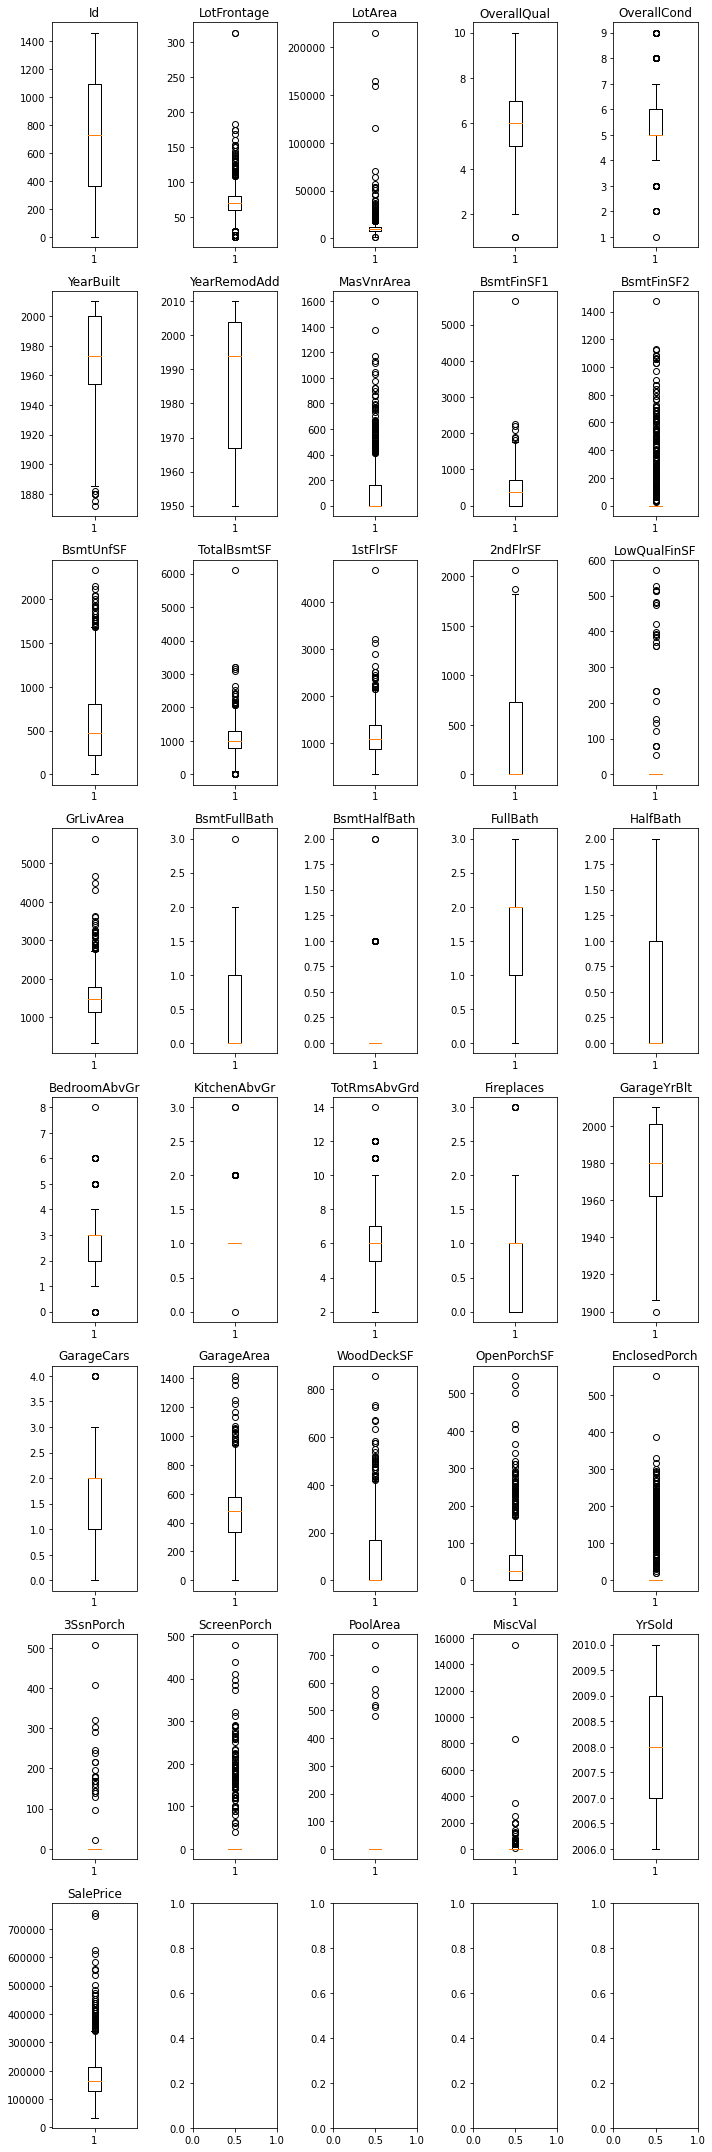

In [62]:
# do box plots for all real numeric columns

fig, axes = plt.subplots(8, 5, figsize=(10, 30))

ax = axes.ravel()

for i, col in enumerate(col_real_num):
    ax[i].boxplot(data[col])
    ax[i].set_title(col)

plt.tight_layout()

#### Some thoughts:
1. I imagine there could be a difference between columns with values <15 and >15
2. Let's try something quick for now: just do RobustScaler on all truly numeric columns other than SalePrice (handles median & quartiles)
    1. Oh but wait: this should be done on training data only, ie after I've done the train-test split<br>
    BTW I can then do cross-validation etc etc on the train dataset

## Train_test_split
Will then do normalisation & cross-validation etc within the Train dataset

In [63]:
# use Id column for indexing
data.set_index('Id', inplace=True)
data.head(3)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice,AgeAtSale,RemodAge,GarageAge,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,Sal

In [64]:
# update the list of relevant truly numeric columns

col_real_num.remove('Id')
col_real_num.remove('SalePrice')

In [65]:
# split data into train & test
# will leave test data doing nothing until some final evaluation
# (will tinker with cross-validation etc within the train data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, data.columns != 'SalePrice'], data['SalePrice'], random_state=0)

display(X_train.shape)
display(y_train.shape)

(1095, 294)

(1095,)

In [66]:
type(X_train)

pandas.core.frame.DataFrame

## Obs! Only handle the train dataset from now on

## Let's normalise truly numeric columns

In [67]:
# get ideces of the columns in the list col_real_num
# (Because columns in numpy array don't have names => we'll need to use indeces to access them for sklearn operations)
col_real_num_index = [data.columns.get_loc(c) for c in col_real_num if c in data]

print("Number of truly numeric columns is {}".format(len(col_real_num_index)))
print(col_real_num_index)

Number of truly numeric columns is 34
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

# make column transformer that scales the desired truly numeric columns
# BTW columns in numpy array don't have names, need to use indeces to access them
col_tran = ColumnTransformer([("rob_scaler", RobustScaler(), col_real_num_index)], remainder='passthrough')

# fit & apply the column transformer on X_train data
col_tran.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('rob_scaler', RobustScaler(),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                  25, 26, 27, 28, 29, ...])])

## Let's just do a few quick predictions

In [69]:
# transform data

X_train = col_tran.transform(X_train)
X_test = col_tran.transform(X_test)

type(X_train)

numpy.ndarray

In [70]:
# Linear regression - Lasso
print("Lasso for regression\n")

from sklearn.linear_model import Lasso
model = Lasso

alpha_values = [1, 100, 250, 300, 350, 400, 10000]

for alpha in alpha_values:
    mo = model(alpha=alpha, max_iter=1000000).fit(X_train, y_train)
    train_score = mo.score(X_train, y_train)
    test_score = mo.score(X_test, y_test)
    print("For alpha of {},\tthe train score is {:.2f} and the test score is {:.3f}.".format(
        alpha, train_score, test_score)) 

Lasso for regression

For alpha of 1,	the train score is 0.94 and the test score is 0.634.
For alpha of 100,	the train score is 0.93 and the test score is 0.715.
For alpha of 250,	the train score is 0.91 and the test score is 0.748.
For alpha of 300,	the train score is 0.90 and the test score is 0.751.
For alpha of 350,	the train score is 0.89 and the test score is 0.750.
For alpha of 400,	the train score is 0.89 and the test score is 0.744.
For alpha of 10000,	the train score is 0.74 and the test score is 0.650.


In [71]:
# => Lasso with alpha=300 gives test_score = 0.751

#### Hm - slow Lasso?
1. Lasso was very slow and not very good (now fixed, does well)
2. Ridge is really fast and does well

=> why?
==> it seems that's (partly) because I kept alpha too low (ie coefficients weren't pushed to zero much at all)<br>
Ig you need a high alpha if you have loads of features or one-hot features or something?

In [72]:
# Linear regression - Ridge
print("Ridge for regression\n")

from sklearn.linear_model import Ridge
model = Ridge

alpha_values = [0.1, 1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 100]

for alpha in alpha_values:
    mo = model(alpha=alpha, max_iter=100000).fit(X_train, y_train)
    train_score = mo.score(X_train, y_train)
    test_score = mo.score(X_test, y_test)
    print("For alpha of {},\tthe train score is {:.2f} and the test score is {:.3f}.".format(
        alpha, train_score, test_score)) 

Ridge for regression

For alpha of 0.1,	the train score is 0.94 and the test score is 0.618.
For alpha of 1,	the train score is 0.94 and the test score is 0.701.
For alpha of 5,	the train score is 0.92 and the test score is 0.745.
For alpha of 10,	the train score is 0.92 and the test score is 0.751.
For alpha of 15,	the train score is 0.91 and the test score is 0.752.
For alpha of 20,	the train score is 0.91 and the test score is 0.751.
For alpha of 25,	the train score is 0.91 and the test score is 0.750.
For alpha of 30,	the train score is 0.91 and the test score is 0.749.
For alpha of 35,	the train score is 0.91 and the test score is 0.748.
For alpha of 40,	the train score is 0.90 and the test score is 0.746.
For alpha of 50,	the train score is 0.90 and the test score is 0.744.
For alpha of 100,	the train score is 0.89 and the test score is 0.737.


In [73]:
# => Ridge with alpha=15 gives test_score = 0.752

In [74]:
# Gradient boosted tree for regression
print("Gradient boosted tree for regression\n")

from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor

from sklearn.metrics import mean_squared_error
error = mean_squared_error

random_state = 10
n_estimators=1000

# try out different learning rates
print("Learning rates\n")
learning_rates = [0.1, 0.109, 0.11, 0.111, 0.12, 0.2]

for learning_rate in learning_rates:
    mo = model(learning_rate = learning_rate, n_estimators=n_estimators, random_state=random_state, max_depth=2).fit(X_train, y_train)
    # n_estimators=100 by default
    # max_dept=3 by default
    train_score = mo.score(X_train, y_train)
    test_score = mo.score(X_test, y_test)
    mse_train = error(y_train, mo.predict(X_train), squared=False)
    mse_test = error(y_test, mo.predict(X_test), squared=False)
    print("For learning_rate of {},\tthe R^2 train score is {:.2f} and the test score is {:.3f}.\nThe RMSE for train is {:.0f}\tand for test it's {:.0f}".format(
        learning_rate, train_score, test_score, mse_train, mse_test)) 
    #print("mo.feature_importances_", mo.feature_importances_)
    
# try out different depths
print("\nMax depths\n")
depths = [1, 2, 3, 4]

for max_depth in depths:
    mo = model(max_depth = max_depth, learning_rate=0.11, random_state=random_state, n_estimators=n_estimators).fit(X_train, y_train)
    # learning_rate=0.1 by default
    train_score = mo.score(X_train, y_train)
    test_score = mo.score(X_test, y_test)
    print("For max_depth of {},\tthe train score is {:.2f} and the test score is {:.2f}.".format(
        max_depth, train_score, test_score)) 
    #print("mo.feature_importances_", mo.feature_importances_)

# could really do a grid-search for the hyperparameters here, Ig

Gradient boosted tree for regression

Learning rates

For learning_rate of 0.1,	the R^2 train score is 0.99 and the test score is 0.914.
The RMSE for train is 7111	and for test it's 23770
For learning_rate of 0.109,	the R^2 train score is 0.99 and the test score is 0.914.
The RMSE for train is 6879	and for test it's 23816
For learning_rate of 0.11,	the R^2 train score is 0.99 and the test score is 0.923.
The RMSE for train is 6624	and for test it's 22596
For learning_rate of 0.111,	the R^2 train score is 0.99 and the test score is 0.899.
The RMSE for train is 6701	and for test it's 25847
For learning_rate of 0.12,	the R^2 train score is 0.99 and the test score is 0.908.
The RMSE for train is 6240	and for test it's 24635
For learning_rate of 0.2,	the R^2 train score is 1.00 and the test score is 0.897.
The RMSE for train is 3799	and for test it's 26070

Max depths

For max_depth of 1,	the train score is 0.96 and the test score is 0.91.
For max_depth of 2,	the train score is 0.99 and the

In [75]:
# => After playing around, it seems that the best I can do (while n_estimators=100) could be something like:
# learning_rate=0.11, max_depth=2
# test_score = 0.90

# With more trees, things could get better: (n_estimators=1000)
# learning_rate=0.11, max_depth=2
# test_score = 0.923

### Kenny: R-squared describes correlation. What we want is to know how close the prediction is to the true value<br>=> mean squared value<br><br>=> some attempt at checking errors: RMSE and RMSPE

In [76]:
model = GradientBoostingRegressor
mo = model(learning_rate = 0.11, n_estimators=1000, random_state=10, max_depth=2).fit(X_train, y_train)

In [77]:
error = mean_squared_error
er = error(y_test, mo.predict(X_test), squared=False)

print("For the test data set, R^2 score is {:0.3f} and RMSE is {:0.0f}".format(mo.score(X_test, y_test), er))

For the test data set, R^2 score is 0.923 and RMSE is 22596


In [78]:
predicted_price = mo.predict(X_test)
true_price = y_test
display(pd.DataFrame(predicted_price))
display(pd.DataFrame(true_price))

rmspe = (np.sqrt(np.mean(np.square((true_price - predicted_price) / true_price)))) * 100
print("RMSPE is {:.2f}".format(rmspe))

rmse = (np.sqrt(np.mean(np.square(true_price - predicted_price))))
print("RMSE is {:.0f}".format(rmse))

,0
0,250170.278876
1,151378.353212
2,112437.226657
3,214759.058579
4,91940.542459
...,...
360,348369.705859
361,190128.207728
362,225397.240064
363,257310.878629


,SalePrice
Id,
530,200624
492,133000
460,110000
280,192000
656,88000
...,...
584,325000
1246,178000
1391,235000


RMSPE is 13.58
RMSE is 22596


## Let's cluster house SalePrice, for fun

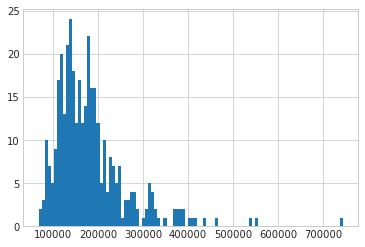

In [79]:
plt.style.use('seaborn-whitegrid')
plt.hist(y_test, bins=100);

In [80]:
from sklearn.cluster import KMeans
print("k-means clustering for SalePrice")

model = KMeans

reshaped = y_train.to_numpy().reshape(-1,1)
mo = model(n_clusters=7, random_state=0).fit(reshaped)

# rounding numbers inside numpy array
# decimals = Number of decimal places to round to (default: 0).
# If decimals is negative, it specifies the number of positions to the left of the decimal point. => so cool!
np.around(mo.cluster_centers_, decimals=-4)

k-means clustering for SalePrice


array([[300000.],
       [140000.],
       [240000.],
       [ 90000.],
       [630000.],
       [410000.],
       [180000.]])

In [81]:
# => not sure it's that useful
# would be nice to indicate cluster centres on the plot of all house values

## Let's try grid search with cross validation

Eg for SVM

In [82]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

print("Support vector machine for regression. With grid search + cross validation")

model = SVR()
parameters = {'kernel':('linear', 'rbf'), 'C':[1.0, 10, 100], 'epsilon':[0.01, 0.2,1]}

reg = GridSearchCV(model, parameters)
reg.fit(X_train, y_train)

print("The best parameters are:")
display(reg.best_params_)

print("And the score is {:.3f}".format(reg.score(X_test, y_test)))

# full outcome of all the models that got tested in grid search
all_params = pd.DataFrame(reg.cv_results_)

# sort the models based on "rank_test_score"
display(all_params.sort_values(by=["rank_test_score"], ascending=True))

Support vector machine for regression. With grid search + cross validation
The best parameters are:


{'C': 100, 'epsilon': 0.01, 'kernel': 'linear'}

And the score is 0.715


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,8.910163,4.722469,0.137039,0.031205,100,0.01,linear,"{'C': 100, 'epsilon': 0.01, 'kernel': 'linear'}",0.852975,0.760361,0.827509,0.794184,0.860235,0.819053,0.037367,1
14,9.221209,5.993975,0.153244,0.000165,100,0.2,linear,"{'C': 100, 'epsilon': 0.2, 'kernel': 'linear'}",0.852975,0.760360,0.827509,0.794183,0.860235,0.819053,0.037367,2
16,7.377150,3.595847,0.153486,0.000360,100,1,linear,"{'C': 100, 'epsilon': 1, 'kernel': 'linear'}",0.852974,0.760358,0.827510,0.794180,0.860236,0.819052,0.037368,3
6,0.907344,0.101153,0.153809,0.000608,10,0.01,linear,"{'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}",0.599063,0.526270,0.552694,0.542771,0.626959,0.569551,0.037526,4
8,0.891026,0.105163,0.153625,0.000461,10,0.2,linear,"{'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}",0.599064,0.526268,0.552694,0.542770,0.626959,0.569551,0.037527,5
10,0.938009,0.113233,0.153504,0.000732,10,1,linear,"{'C': 10, 'epsilon': 1, 'kernel': 'linear'}",0.599069,0.526263,0.552696,0.542766,0.626958,0.569550,0.037529,6
4,0.697003,0.015232,0.153435,0.000926,1,1,linear,"{'C': 1.0, 'epsilon': 1, 'kernel': 'linear'}",0.379921,0.299475,0.319955,0.349055,0.404934,0.350668,0.038385,7
2,0.700667,0.019306,0.152225,0.003779,1,0.2,linear,"{'C': 1.0, 'epsilon': 0.2, 'kernel': 'linear'}",0.379918,0.299482,0.319956,0.349050,0.404931,0.350667,0.038382,8
0,0.700796,0.016300,0.152825,0.002120,1,0.01,linear,"{'C': 1.0, 'epsilon': 0.01, 'kernel': 'linear'}",0.379917,0.299484,0.319957,0.349049,0.404930,0.350667,0.038381,9
13,0.716815,0.001434,0.171132,0.000946,100,0.01,rbf,"{'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}",-0.011084,-0.097977,-0.095109,-0.035280,-0.010526,-0.049995,0.039054,10


In [83]:
# to speed things up, let's use ShuffleSplit in cv to reduce the number of samples that are used
# later addition - try MSE as the scoring parameter (after all, that's what we actually want to minimise atm)

from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

print("Support vector machine for regression. With grid search + cross validation")

model = LinearSVR(max_iter=1000000)
parameters = {'C':[800, 850], 'epsilon':[0.1, 0.25]}

# only use 10% of the data in total => hope things should be quicker
shuffle_split = ShuffleSplit(train_size=0.07, test_size=0.03, n_splits=1)

# default scoring='r2'
reg = GridSearchCV(model, parameters, cv=shuffle_split, scoring='neg_root_mean_squared_error')
reg.fit(X_train, y_train)

print("The best parameters are:")
display(reg.best_params_)

print("And the score is {:.3f}".format(reg.score(X_test, y_test)))

# full outcome of all the models that got tested in grid search
all_params = pd.DataFrame(reg.cv_results_)

# sort the models based on "rank_test_score"
display(all_params.sort_values(by=["rank_test_score"], ascending=True))

Support vector machine for regression. With grid search + cross validation
The best parameters are:


/home/bkotryna/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


{'C': 850, 'epsilon': 0.25}

And the score is -40556.915


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
3,0.666511,0.0,0.000983,0.0,850,0.25,"{'C': 850, 'epsilon': 0.25}",-34300.667954,-34300.667954,0.0,1
2,0.712533,0.0,0.000990,0.0,850,0.1,"{'C': 850, 'epsilon': 0.1}",-34309.387532,-34309.387532,0.0,2
0,0.526585,0.0,0.001109,0.0,800,0.1,"{'C': 800, 'epsilon': 0.1}",-34744.829994,-34744.829994,0.0,3
1,0.683803,0.0,0.000994,0.0,800,0.25,"{'C': 800, 'epsilon': 0.25}",-34791.184593,-34791.184593,0.0,4


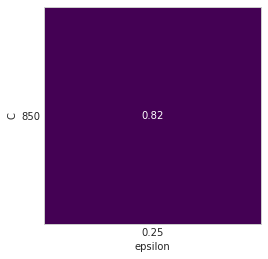

In [111]:
# visualise grid search outcomes

scores = np.array(all_params["mean_test_score"]).reshape(len(parameters['C']),len(parameters['epsilon']))

mglearn.tools.heatmap(scores, xlabel='epsilon', ylabel='C',
                      xticklabels=parameters['epsilon'], yticklabels=parameters['C'],
                      cmap='viridis')

In [112]:
# obtain RMSE and RMSPE for the model with best parameters

predicted_price = reg.predict(X_test)
true_price = y_test

rmspe = (np.sqrt(np.mean(np.square((true_price - predicted_price) / true_price)))) * 100
print("RMSPE is {:.0f} %".format(rmspe))

rmse = (np.sqrt(np.mean(np.square(true_price - predicted_price))))
print("RMSE is $ {:.0f}k".format(rmse / 1000))

RMSPE is 23 %
RMSE is $ 41k


## Conclusions so far

1. Gradient-boosted regression tree had:<br>
Learning_rate=0.11, max_depth=2, n_estimators=1000 and gave:<br><br>
R^2 of 0.923,<br>RMSE of 23k<br>RMSPE of 14%.<br><br>

2. Briefly explored grid search and cross validation for SVM<br><br>
Best SVM had:<br>
C=850, epsilon=0.25 and gave:<br><br>
R^2 of 0.751,<br>RMSE of 41k,<br>RMSPE of 23%.